### Agent-Based Model of Norm Transitions

#### Agent Behaviors:

1. **Initialization:**
   - Each agent starts with a certain amount of wealth and a norm, which can be either self-centric or altruistic.

2. **Wealth Generation:**
   - Agents increase their wealth through two mechanisms:
     - **Proportional Income:** A percentage of their current wealth is added to simulate investment returns.
     - **Fixed Income:** A fixed amount of wealth is added to simulate basic income or wages.

3. **Trade:**
   - At each time step, agents are randomly paired to trade.
   - The wealthier agent offers a trade amount based on a fixed fraction of their wealth.
   - The trade is accepted if it increases the poorer agent's wealth, leading to an update in both agents' wealth.

4. **Norm Transition:**
   - **Interaction Influence:**
     - When a self-centric agent interacts with an altruistic one, it evaluates if adopting an altruistic norm would have increased its utility.
     - If yes, the agent may switch to altruistic with a given probability.
   - **Spontaneous Transition:**
     - Any self-centric agent has a small fixed probability of becoming altruistic spontaneously, regardless of interactions.

5. **Utility Calculation:**
   - **Self-Centric Utility:** Agents derive utility purely from their own wealth.
   - **Altruistic Utility:** Agents derive higher utility when their wealth is similar to the average wealth of the population, promoting equality.

#### Environment:

- The model consists of a fixed number of agents placed in a 2D grid.
- Agents interact with each other through trade and influence each other's norms.
- The simulation runs for a predefined number of steps, during which agents’ wealth and norms evolve based on their behaviors and interactions.

In [ ]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

from mesa.time import RandomActivation
from mesa.space import MultiGrid
import random

In [2]:
class EconomicAgent(mesa.Agent):
    def __init__(self, unique_id, model, initial_wealth, norm):
        super().__init__(unique_id, model)
        self.wealth = initial_wealth
        self.norm = norm
    
    def step(self):
        self.generate_wealth()
        self.expenditure()
        self.trade()
        # self.update_norm()

    def get_utility(self):
        if self.norm == 'self-centric':
            return self.wealth
        elif self.norm == 'altruistic':
            # Compute the gini coefficient of the wealth distribution.
            wealths = [agent.wealth for agent in self.model.schedule.agents]
            gini = self.model.compute_gini(wealths)
            return self.wealth + self.wealth * (1 - gini)

    def generate_wealth(self):
        # Proportional wealth increase.
        self.wealth *= 1 + self.model.growth_rate

        # Fixed wealth increase which emulates a salary from a job. # This should depend on employment status.
        self.wealth += self.model.salary

    def expenditure(self):
        self.wealth -= self.model.expenditure

    def trade(self):
        # Randomly select a trading partner.
        partner = self.random.choice(self.model.schedule.agents)

        # Check if partner is self.
        if partner == self:
            return
        
        # Wealth transfer.
        wealthier, poorer = (self, partner) if self.wealth > partner.wealth else (partner, self)

        # Transfer a portion of wealth based on the trade rate.
        transfer = self.model.trade_rate * wealthier.wealth

        # Transfer the wealth if it improves the poorer agent's wealth
        if poorer.wealth + transfer >= poorer.wealth:
            wealthier.wealth -= transfer
            poorer.wealth += transfer

    def update_norm(self):
        if self.norm == 'self-centric':
            # Interact with random agent
            partner = self.random.choice(self.model.schedule.agents)

            # Check the norm of the partner
            if partner.norm == 'altruistic':
                current_utility = self.get_utility()
                partner_utility = partner.get_utility()

                # Check if the partner's utility is greater than the current utility
                if partner_utility > current_utility:
                    # Check if the conversion probability is met
                    if self.random.random() < self.model.conversion_probability:
                        self.norm = 'altruistic'

        elif self.norm == 'altruistic':
            # Interact with random agent
            partner = self.random.choice(self.model.schedule.agents)

            # Check the norm of the partner
            if partner.norm == 'self-centric':
                current_utility = self.get_utility()
                partner_utility = partner.get_utility()

                # Check if the partner's utility is greater than the current utility
                if partner_utility > current_utility:
                    # Check if the conversion probability is met
                    if self.random.random() < self.model.conversion_probability:
                        self.norm = 'self-centric'




class EconomicModel(mesa.Model):
    def __init__(self, num_agents, initial_wealth, growth_rate, trade_rate, salary, expenditure, conversion_probability, social_pressure_probability, ratio_of_altruistic_agents):
        self.num_agents = num_agents
        self.initial_wealth = initial_wealth
        self.growth_rate = growth_rate
        self.trade_rate = trade_rate
        self.salary = salary
        self.expenditure = expenditure
        self.conversion_probability = conversion_probability
        self.social_pressure_probability = social_pressure_probability

        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width=10, height=10, torus=True)

        # Create agents
        for i in range(self.num_agents):
            norm = 'self-centric' if random.random() > ratio_of_altruistic_agents else 'altruistic'
            agent = EconomicAgent(i, self, self.initial_wealth, norm)
            self.schedule.add(agent)

            # Add the agent to a random grid cell.
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))


    def step(self):
        self.schedule.step()
        

    def compute_gini(self, wealths):
        # Sort the wealths.
        wealths = np.sort(wealths)

        # Get the number of agents.
        n = len(wealths)

        # Get the cumulative wealth.
        cumulative_wealth = np.cumsum(wealths)

        # Calculate the Lorenz curve.
        lorenz_curve = cumulative_wealth / cumulative_wealth[-1]

        # Calculate the Gini coefficient.
        gini = 1 - 2 * np.trapz(lorenz_curve)

        return gini


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_19440/859142975.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


<Axes: xlabel='wealth', ylabel='Count'>

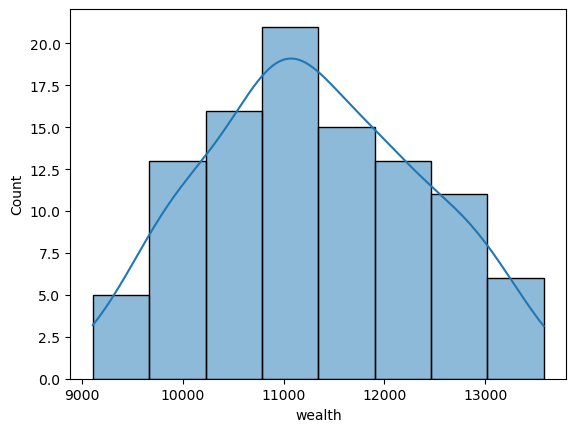

In [4]:
# Set the model parameters.
num_agents = 100
initial_wealth = 1000
growth_rate = 0.01
trade_rate = 0.1
salary = 100
expenditure = 50
conversion_probability = 0.4
social_pressure_probability = 0.1
ratio_of_altruistic_agents = 0.2

# Create the model.
model = EconomicModel(num_agents, initial_wealth, growth_rate, trade_rate, salary, expenditure, conversion_probability, social_pressure_probability, ratio_of_altruistic_agents)

# Run the model.
for i in range(100):
    model.step()

# Get the wealths of the agents.
wealths = [agent.wealth for agent in model.schedule.agents]

# Create a DataFrame.
df = pd.DataFrame({'wealth': wealths})

# Plot the wealth distribution.
sns.histplot(df['wealth'], kde=True)


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_19495/859142975.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


<Axes: xlabel='wealth', ylabel='Count'>

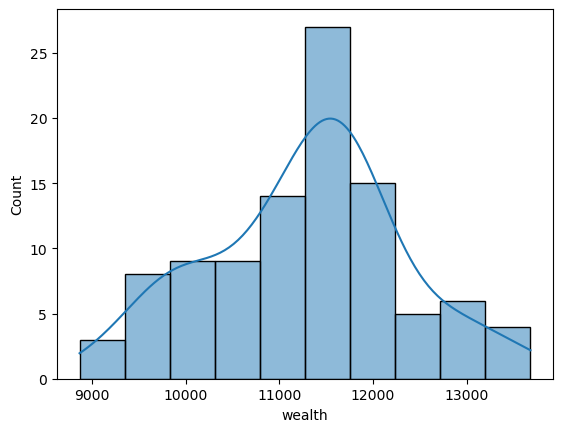

In [3]:
# Set the model parameters.
num_agents = 100
initial_wealth = 1000
growth_rate = 0.01
trade_rate = 0.1
salary = 100
expenditure = 50
conversion_probability = 0.4
social_pressure_probability = 0.1
ratio_of_altruistic_agents = 0.8

# Create the model.
model = EconomicModel(num_agents, initial_wealth, growth_rate, trade_rate, salary, expenditure, conversion_probability, social_pressure_probability, ratio_of_altruistic_agents)

# Run the model.
for i in range(100):
    model.step()

# Get the wealths of the agents.
wealths = [agent.wealth for agent in model.schedule.agents]

# Create a DataFrame.
df = pd.DataFrame({'wealth': wealths})

# Plot the wealth distribution.
sns.histplot(df['wealth'], kde=True)


/var/folders/l1/cbpvtb4x2c38sfgzlzdply84c5jfvg/T/ipykernel_19495/859142975.py:3: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


<Axes: xlabel='wealth', ylabel='Count'>

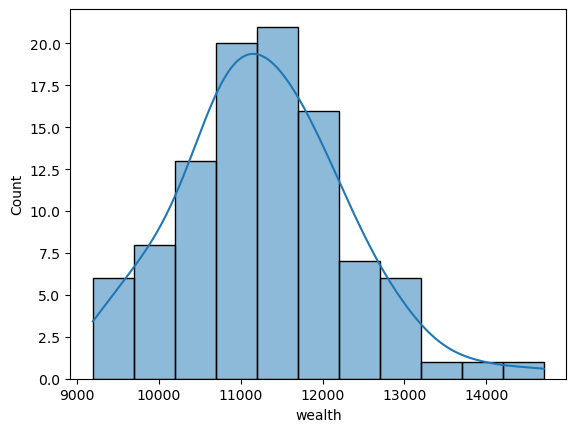

In [4]:
# Set the model parameters.
num_agents = 100
initial_wealth = 1000
growth_rate = 0.01
trade_rate = 0.1
salary = 100
expenditure = 50
conversion_probability = 0.4
social_pressure_probability = 0.1
ratio_of_altruistic_agents = 0

# Create the model.
model = EconomicModel(num_agents, initial_wealth, growth_rate, trade_rate, salary, expenditure, conversion_probability, social_pressure_probability, ratio_of_altruistic_agents)

# Run the model.
for i in range(100):
    model.step()

# Get the wealths of the agents.
wealths = [agent.wealth for agent in model.schedule.agents]

# Create a DataFrame.
df = pd.DataFrame({'wealth': wealths})

# Plot the wealth distribution.
sns.histplot(df['wealth'], kde=True)
